# Modular RNN proof of concept

The idea here is to just build a working LSTM that takes 2D data at each timestep and trains with batches. We should do this with a minimum of code. Once we have this working, we can apply it to more interesting things...like building Artiste!

In [1]:
import numpy as np
import tensorflow as tf

import time
import cPickle as pickle
import matplotlib.pyplot as plt
import matplotlib.cm as cm
%matplotlib inline

## Build model

In [2]:
class SequentialModel():
    def __init__(self, batch_size, tsteps, xlen, ylen, lr):
        self.sess = tf.InteractiveSession()
        self.batch_size = batch_size
        self.tsteps = tsteps
        self.xlen = xlen
        self.ylen = ylen
        self.lr = lr
        self.x = x = tf.placeholder(tf.float32, shape=[None, None, xlen], name="x")
        self.y = y = tf.placeholder(tf.float32, shape=[None, None, ylen], name="y")
        
        self.params = params = {}
        self.fc1_size = fc1_size = 5
        self.rnn_size = rnn_size = 50
        with tf.variable_scope('sketch',reuse=False):
            xavier_l1 = tf.truncated_normal_initializer(mean=0, stddev=1./np.sqrt(ylen), dtype=tf.float32)
            params['W1'] = tf.get_variable("W1", [xlen, fc1_size], initializer=xavier_l1)

            rnn_init = tf.truncated_normal_initializer(stddev=0.075, dtype=tf.float32)
            params['rnn'] = tf.nn.rnn_cell.LSTMCell(rnn_size, state_is_tuple=True, initializer=rnn_init)

            params['istate_batch'] = params['rnn'].zero_state(batch_size=batch_size, dtype=tf.float32)
            params['istate'] = params['rnn'].zero_state(batch_size=1, dtype=tf.float32)

            xavier_l3 = tf.truncated_normal_initializer(stddev=1./np.sqrt(rnn_size), dtype=tf.float32)
            params['W3'] = tf.get_variable("W3", [rnn_size, ylen], initializer=xavier_l3)
            
        y_hat_batch, params['fstate_batch'] = self.sketch_forward(params['istate_batch'], tsteps=tsteps, reuse=False)
        self.y_hat, params['fstate'] = self.sketch_forward(params['istate'], tsteps=1, reuse=True)
        
        self.loss = tf.nn.l2_loss(y - y_hat_batch) / batch_size
        self.optimizer = tf.train.AdamOptimizer(lr)
        self.grads = self.optimizer.compute_gradients(self.loss, var_list=tf.trainable_variables())
        self.train_op = self.optimizer.apply_gradients(self.grads)

        self.sess.run(tf.initialize_all_variables())
            
    def sketch_forward(self, state, tsteps, reuse=False):
        with tf.variable_scope('sketch', reuse=reuse):
            x = tf.reshape(self.x, [-1, 2])
            h = tf.matmul(x, self.params['W1'])
            h = tf.nn.relu(h) # ReLU nonlinearity

            hs = [tf.squeeze(h_, [1]) for h_ in tf.split(1, tsteps, tf.reshape(h, [-1, tsteps, self.fc1_size]))]
            rnn_outs, state = tf.nn.seq2seq.rnn_decoder(hs, state, self.params['rnn'], scope='sketch')
            rnn_out = tf.reshape(tf.concat(1, rnn_outs), [-1, self.rnn_size])

            logps = tf.matmul(rnn_out, self.params['W3'])
            p = tf.reshape(logps, [-1, tsteps, self.ylen])
        return p, state
    
    def train_step(self, batch):
        feed = {self.x: batch[0], self.y: batch[1]}
        train_loss, _ = self.sess.run([self.loss, self.train_op], feed_dict=feed)
        return train_loss
    
    def generate(self, steps_forward):
        prev_coord = np.asarray([[[0,1]]]) #np.zeros((1,1,self.xlen))
        pts = np.zeros((1,0,self.ylen))
        c, h = self.params['istate'].c.eval(), self.params['istate'].h.eval()

        for t in range(steps_forward):
            pts = np.concatenate((pts,prev_coord), axis=1)
            feed = {self.x: prev_coord, self.params['istate'].c: c, self.params['istate'].h: h}
            fetch = [self.y_hat, self.params['fstate'].c, self.params['fstate'].h]
            [prev_coord, c, h] = self.sess.run(fetch, feed)
        return pts

## Parameters

In [3]:
global_step = 0
save_path = 'models/model.ckpt'
model = SequentialModel(batch_size=32, tsteps=30, xlen=2, ylen=2, lr=1e-4)

## Model overview

In [4]:
total_parameters = 0 ; print "Model overview:"
for variable in tf.trainable_variables():
    shape = variable.get_shape()
    variable_parameters = 1
    for dim in shape:
        variable_parameters *= dim.value
    print '\tvariable "{}" has {} parameters' \
        .format(variable.name, variable_parameters)
    total_parameters += variable_parameters
print "Total of {} parameters".format(total_parameters)

Model overview:
	variable "sketch/W1:0" has 10 parameters
	variable "sketch/W3:0" has 100 parameters
	variable "sketch/sketch/LSTMCell/W_0:0" has 11000 parameters
	variable "sketch/sketch/LSTMCell/B:0" has 200 parameters
Total of 11310 parameters


## Load saved weights

In [5]:
saver = tf.train.Saver(tf.all_variables())
load_was_success = True # yes, I'm being optimistic
try:
    save_dir = '/'.join(save_path.split('/')[:-1])
    ckpt = tf.train.get_checkpoint_state(save_dir)
    load_path = ckpt.model_checkpoint_path
    saver.restore(sess, load_path)
except:
    print "no saved model to load. starting new session"
    load_was_success = False
else:
    print "loaded model: {}".format(load_path)
    saver = tf.train.Saver(tf.all_variables())
    global_step = int(load_path.split('-')[-1])

no saved model to load. starting new session


## Synthesize data

In [6]:
def next_batch(batch_size, tsteps, ylen, noise=0.05):
    x = np.reshape( np.linspace(0, 2*np.pi,tsteps), (-1,1))
    y = np.hstack([np.cos(x), np.sin(x)])
    y -= np.concatenate((y[-1:,:], y[:-1,:]), axis=0)
    z = np.concatenate((y[-1:,:], y[:-1,:]), axis=0)
    
    y = [y]*batch_size ; y = [b + noise*np.random.normal(size=b.shape) for b in y]
    z = [z]*batch_size ; z = [b + noise*np.random.normal(size=b.shape) for b in z]
    return y,z

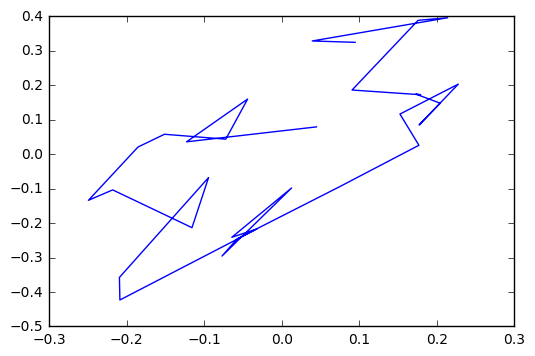

In [7]:
p,q = next_batch(model.batch_size, model.tsteps, model.ylen)
k = np.cumsum(p[0],axis=1)
plt.plot(k[:,0], k[:,1])

## Train vision models

In [8]:
begin = time.time()
np_state = model.params['istate']
for i in range(global_step, 500):
    start = time.time()
    
    batch = next_batch(model.batch_size, model.tsteps, model.ylen)
    train_loss = model.train_step(batch)
    
    if global_step%100 == 0:
        print "\tstep {}, loss {:3f}, batch time {:3f}".format(i, train_loss, time.time()-start)
    global_step += 1
        
# saver.save(sess, save_path, global_step=global_step)
# print "SAVED MODEL #{}".format(global_step)
print "\ntotal runtime: {:3f} seconds".format(time.time()-begin)

	step 0, loss 0.694082, batch time 0.211760
	step 100, loss 0.532939, batch time 0.023384
	step 200, loss 0.202468, batch time 0.022932
	step 300, loss 0.136985, batch time 0.023144
	step 400, loss 0.114549, batch time 0.022723

total runtime: 12.545354 seconds


## Generate with model

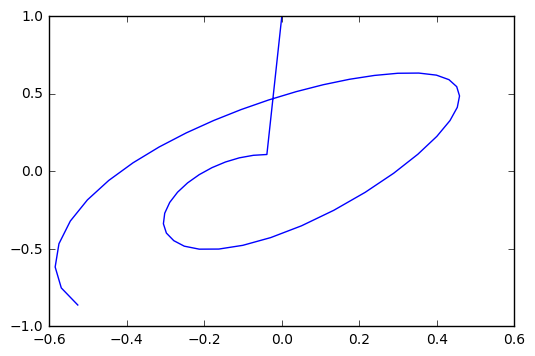

In [9]:
pts = model.generate(steps_forward=50)
t = np.cumsum(pts[0,:,:],axis=1)
plt.plot(t[:,0], t[:,1])